# 512×512 Image & Mask Tiling

Generated masks and tiles for model training.


**Tiling 512 x 512**

In [ ]:
def tile_image_and_mask(image, mask, tile_size=512):
    """
    image: (C, H, W)   e.g., RGB as (3, H, W)
    mask:  (H, W)      uint8 labels 0..3 (and possibly 255 if you used UNASSIGNED)
    returns: list of (image_tile, mask_tile)
             image_tile: (C, tile_size, tile_size)
             mask_tile:  (tile_size, tile_size)
    """
    C, H, W = image.shape
    tiles = []

    max_y = (H // tile_size) * tile_size
    max_x = (W // tile_size) * tile_size

    for y in range(0, max_y, tile_size):
        for x in range(0, max_x, tile_size):
            img_tile = image[:, y:y+tile_size, x:x+tile_size]
            msk_tile = mask[y:y+tile_size, x:x+tile_size]

            if img_tile.shape[1:] == (tile_size, tile_size) and msk_tile.shape == (tile_size, tile_size):
                tiles.append((img_tile, msk_tile))

    return tiles

In [ ]:
TILE_SIZE = 512

DATA_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/RGB_Prep_Demo")
MASK_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/RGB_Prep_Demo/labels_ndvi_ndwi")

tif_paths = sorted(DATA_DIR.glob("*.tif"))
print("Num image TIFFs:", len(tif_paths))

sample_path = tif_paths[0]
stem = sample_path.stem
mask_path = MASK_DIR / f"{stem}_mask_0_3.tif"

print("Sample image:", sample_path.name)
print("Sample mask :", mask_path.name, "| exists:", mask_path.exists())

# Read image + mask
with rasterio.open(sample_path) as src_img:
    bands = src_img.read()  # (4, H, W)
    print("Image bands shape:", bands.shape)
    rgb = bands[:3, :, :]   # (3, H, W)

with rasterio.open(mask_path) as src_msk:
    mask = src_msk.read(1)  # (H, W)
    print("Mask shape:", mask.shape, "dtype:", mask.dtype)

# Ensure expected dtype for class labels
mask = mask.astype(np.uint8)

# Tile
tiles = tile_image_and_mask(rgb, mask, tile_size=TILE_SIZE)
print("Num tiles:", len(tiles))

# Inspect first tile
rgb_t, m_t = tiles[0]
labels, counts = np.unique(m_t, return_counts=True)

print("Tile RGB shape:", rgb_t.shape)
print("Tile mask shape:", m_t.shape)
print("Tile unique labels:", labels)


Num image TIFFs: 15
Sample image: 930645_se.tif
Sample mask : 930645_se_mask_0_3.tif | exists: True
Image bands shape: (4, 5000, 5000)
Mask shape: (5000, 5000) dtype: uint8
Num tiles: 81
Tile RGB shape: (3, 512, 512)
Tile mask shape: (512, 512)
Tile unique labels: [0 1 2 3]


**Sanity Check for Tiles**

Num image tiles: 1215
930645_se_y3584_x4096.png unique mask labels: [0 1 2 3]
930660_se_y2048_x1536.png unique mask labels: [0 1 2 3]
930675_se_y2560_x3584.png unique mask labels: [1 2 3]


/tmp/ipython-input-3298826129.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


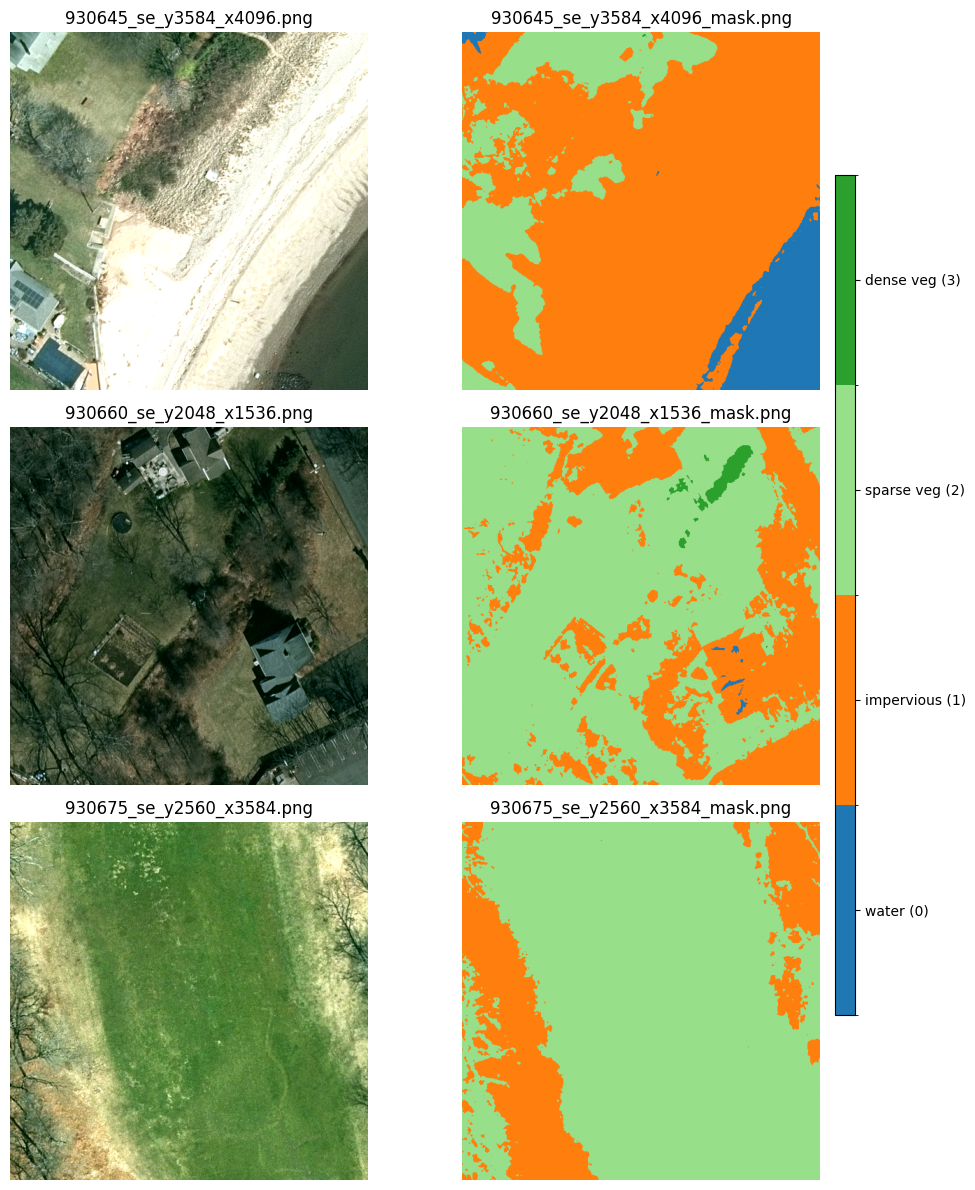

In [ ]:
TILES_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset_tiles_512")
IMG_OUT = TILES_BASE / "images"
MSK_OUT = TILES_BASE / "masks"

img_files = sorted(list(IMG_OUT.glob("*.png")))
print("Num image tiles:", len(img_files))

# pick a few random tiles
k = 3
sample_imgs = random.sample(img_files, k)


class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]  # 0 water,1 imperv,2 sparse,3 dense
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

fig, axs = plt.subplots(k, 2, figsize=(10, 4*k))

for i, img_fp in enumerate(sample_imgs):
    msk_fp = MSK_OUT / f"{img_fp.stem}_mask.png"
    if not msk_fp.exists():
        print("Missing mask tile for:", img_fp.name)
        continue

    rgb = np.array(Image.open(img_fp))
    mask = np.array(Image.open(msk_fp))

    axs[i, 0].imshow(rgb)
    axs[i, 0].set_title(img_fp.name)
    axs[i, 0].axis("off")

    im = axs[i, 1].imshow(mask, cmap=cmap_mask, norm=norm_mask)
    axs[i, 1].set_title(msk_fp.name)
    axs[i, 1].axis("off")

    # print mask unique labels for each tile (quick check)
    u = np.unique(mask)
    print(img_fp.name, "unique mask labels:", u)

# one legend/colorbar for the mask column
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(
    im,
    cax=cax,
    ticks=[0, 1, 2, 3]
)
cbar.set_ticklabels([
    "water (0)",
    "impervious (1)",
    "sparse veg (2)",
    "dense veg (3)"
])
plt.tight_layout()
plt.show()
